## **Installing LibAUC**

Let's start with install our library here. In this tutorial, we will use version `1.2.0`.

In [1]:
! pip install libauc==1.2.0
! pip install medmnist

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


# **Importing LibAUC**
Import required libraries to use

In [2]:
from libauc.losses import AUCMLoss
from libauc.optimizers import PESG
from libauc.models import resnet20 as ResNet20
from libauc.datasets import CIFAR10
from libauc.utils import ImbalancedDataGenerator
from libauc.sampler import DualSampler
from libauc.metrics import auc_roc_score, auc_prc_score

import torch 
from PIL import Image
import numpy as np
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from sklearn.metrics import roc_auc_score
from libauc.models import resnet18

## **Reproducibility**

These functions limit the number of sources of randomness behaviors, such as model intialization, data shuffling, etcs. However, completely reproducible results are not guaranteed across PyTorch releases [[Ref]](https://pytorch.org/docs/stable/notes/randomness.html#:~:text=Completely%20reproducible%20results%20are%20not,even%20when%20using%20identical%20seeds.).

In [3]:
def set_all_seeds(SEED):
    # REPRODUCIBILITY
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

## **Image Dataset**


Now that we defined the data input pipeline such as data augmentations. In this tutorials, we use `RandomCrop`, `RandomHorizontalFlip`.




In [4]:
class ImageDataset(Dataset):
    def __init__(self, images, targets, image_size=32, crop_size=28, mode='train'):
       self.images = images.astype(np.uint8)
       self.targets = targets
       self.mode = mode
       self.transform_train = transforms.Compose([                                                
                              transforms.ToTensor(),
                              transforms.RandomCrop((crop_size, crop_size), padding=None),
                              transforms.RandomHorizontalFlip(),
                              transforms.Resize((image_size, image_size)),
                              ])
       self.transform_test = transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Resize((image_size, image_size)),
                              ])
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        target = self.targets[idx]
        image = Image.fromarray(image.astype('uint8'))
        if self.mode == 'train':
            image = self.transform_train(image)
        else:
            image = self.transform_test(image)
        return image, target

# HyperParameters

In [5]:
SEED = 123
BATCH_SIZE = 64
imratio = 0.1 # for demo 
total_epochs = 15
decay_epochs = [9]
margin = 1.0
epoch_decay = 0.003 # refers gamma in the paper
weight_decay = 0

# oversampling minority class, you can tune it in (0, 0.5]
# e.g., sampling_rate=0.2 is that num of positive samples in mini-batch is sampling_rate*batch_size=13
sampling_rate = 0.2

# **Loading datasets**

In [6]:
# load data as numpy arrays 
#train_data, train_targets = CIFAR10(root='./data', train=True)
#test_data, test_targets  = CIFAR10(root='./data', train=False)

# Load PneumoniaMNIST datasets
from medmnist import PneumoniaMNIST
train_dataset = PneumoniaMNIST(split='train', download=True)
test_dataset = PneumoniaMNIST(split='test', download=True)

# generate imbalanced data
generator = ImbalancedDataGenerator(verbose=True, random_seed=0)
(train_images, train_labels) = generator.transform(train_dataset.imgs, train_dataset.labels, imratio=imratio)
(test_images, test_labels) = generator.transform(test_dataset.imgs, test_dataset.labels, imratio=0.5) 

# data augmentations 
trainSet = ImageDataset(train_images, train_labels)
trainSet_eval = ImageDataset(train_images, train_labels, mode='test')
testSet = ImageDataset(test_images, test_labels, mode='test')

# dataloaders
sampler = DualSampler(trainSet, BATCH_SIZE, sampling_rate=sampling_rate)
trainloader = torch.utils.data.DataLoader(trainSet, batch_size=BATCH_SIZE, sampler=sampler, num_workers=2)
trainloader_eval = torch.utils.data.DataLoader(trainSet_eval, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(testSet, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

Using downloaded and verified file: /home/grads/s/skpaul/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /home/grads/s/skpaul/.medmnist/pneumoniamnist.npz
#SAMPLES: [1348], POS:NEG: [134 : 1214], POS RATIO: 0.0994
#SAMPLES: [624], POS:NEG: [390 : 234], POS RATIO: 0.6250


In [7]:
# Modify ResNet18 to work with grayscale images
def get_resnet18():
    # Replace the first convolution layer of ResNet18(model.conv1) with a convolution layer of only 1 input channel(original ResNet is designed for RGB image input)
    model = resnet18(pretrained=False, last_activation=None)
    model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    return model

# **Training**

In [8]:
def train_model(model, loss_fn, optimizer, scheduler, num_epochs=15, decay_epochs=[9]):
    print ('Start Training')
    print ('-'*30)

    train_log_roc = []
    test_log_roc = []
    train_log_prc = []
    test_log_prc = []
    for epoch in range(num_epochs):
        if epoch in decay_epochs:
            optimizer.update_regularizer(decay_factor=10) # decrease learning rate by 10x & update regularizer
    
        train_loss = []
        model.train()    
        for data, targets in trainloader:
            data, targets  = data.cuda(), targets.cuda()
            y_pred = model(data)
            y_pred = torch.sigmoid(y_pred)
            loss = loss_fn(y_pred, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
        
        # evaluation on train & test sets
        model.eval()
        train_pred_list = []
        train_true_list = []
        for train_data, train_targets in trainloader_eval:
            train_data = train_data.cuda()
            train_pred = model(train_data)
            train_pred_list.append(train_pred.cpu().detach().numpy())
            train_true_list.append(train_targets.numpy())
        train_true = np.concatenate(train_true_list)
        train_pred = np.concatenate(train_pred_list)
        train_auc = auc_roc_score(train_true, train_pred)
        train_ap = auc_prc_score(train_true, train_pred)
        train_loss = np.mean(train_loss)
    
        test_pred_list = []
        test_true_list = [] 
        for test_data, test_targets in testloader:
            test_data = test_data.cuda()
            test_pred = model(test_data)
            test_pred_list.append(test_pred.cpu().detach().numpy())
            test_true_list.append(test_targets.numpy())
        test_true = np.concatenate(test_true_list)
        test_pred = np.concatenate(test_pred_list)
        val_auc =  auc_roc_score(test_true, test_pred)
        test_ap = auc_prc_score(test_true, test_pred)
        model.train()
    
        # print results
        print("epoch: %s, train_loss: %.4f, train_auc: %.4f, test_auc: %.4f, train_ap: %.4f, test_ap: %.4f, lr: %.4f"%(epoch, train_loss, train_auc, val_auc, train_ap, test_ap, optimizer.lr ))    
        train_log_roc.append(train_auc) 
        test_log_roc.append(val_auc)
        train_log_prc.append(train_ap)
        test_log_prc.append(test_ap)
    return  train_log_roc, test_log_roc, train_log_prc, test_log_prc

# **Visualization**
Now, let's see the learning curve of optimizing AUROC on train and tes sets. 


In [ ]:
import matplotlib.pyplot as plt

def plot_curves(train_auprc, test_auprc, train_auroc, test_auroc, model_name):
    plt.rcParams["figure.figsize"] = (9,5)
    x=np.arange(len(train_auroc))
    plt.figure()
    plt.plot(x, train_auroc, linestyle='-', label='Train AUROC', linewidth=3)
    plt.plot(x, test_auroc,  linestyle='-', label='Test AUROC', linewidth=3)
    plt.plot(x, train_auprc, linestyle='--', label='Train AUPRC', linewidth=3)
    plt.plot(x, test_auprc,  linestyle='--', label='Test AUPRC', linewidth=3)
    plt.title(f'AUPRC and AUROC for {model_name}',fontsize=25)
    plt.legend(fontsize=15)
    plt.ylabel('Score', fontsize=25)
    plt.xlabel('Epoch', fontsize=25)

In [10]:
lr_PESG = [0.02, 0.05, 0.1]

Start Training
------------------------------
epoch: 0, train_loss: 0.0891, train_auc: 0.8052, test_auc: 0.6679, train_ap: 0.3622, test_ap: 0.7467, lr: 0.0200
epoch: 1, train_loss: 0.0786, train_auc: 0.9622, test_auc: 0.8825, train_ap: 0.7990, test_ap: 0.9129, lr: 0.0200
epoch: 2, train_loss: 0.0306, train_auc: 0.9887, test_auc: 0.9218, train_ap: 0.9691, test_ap: 0.9467, lr: 0.0200
epoch: 3, train_loss: 0.0020, train_auc: 0.9913, test_auc: 0.9352, train_ap: 0.9805, test_ap: 0.9588, lr: 0.0200
epoch: 4, train_loss: -0.0111, train_auc: 0.9951, test_auc: 0.9337, train_ap: 0.9855, test_ap: 0.9582, lr: 0.0200
epoch: 5, train_loss: -0.0126, train_auc: 0.9987, test_auc: 0.9285, train_ap: 0.9946, test_ap: 0.9538, lr: 0.0200
epoch: 6, train_loss: -0.0128, train_auc: 0.9988, test_auc: 0.9206, train_ap: 0.9955, test_ap: 0.9488, lr: 0.0200
epoch: 7, train_loss: -0.0103, train_auc: 0.9983, test_auc: 0.9243, train_ap: 0.9950, test_ap: 0.9519, lr: 0.0200
epoch: 8, train_loss: -0.0094, train_auc: 0.99

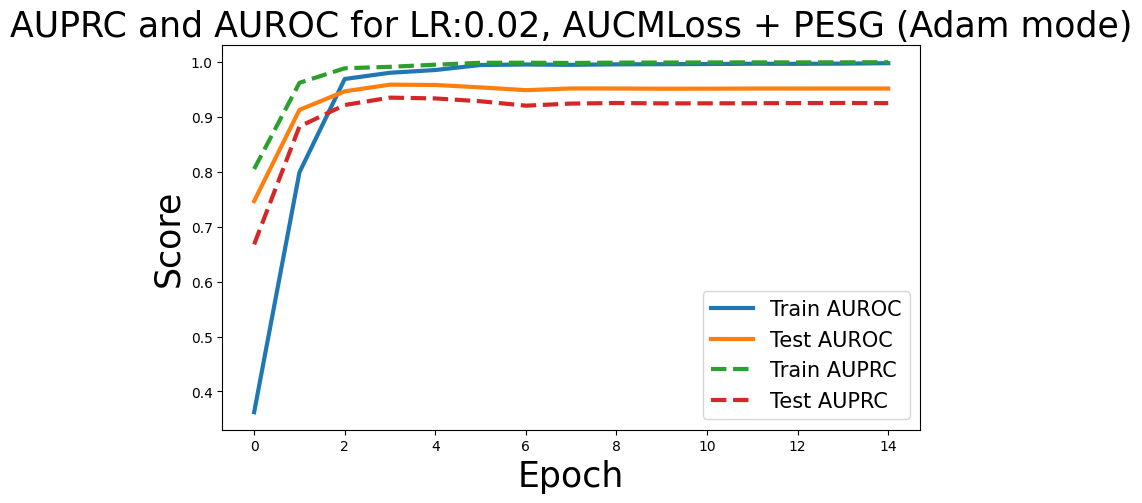

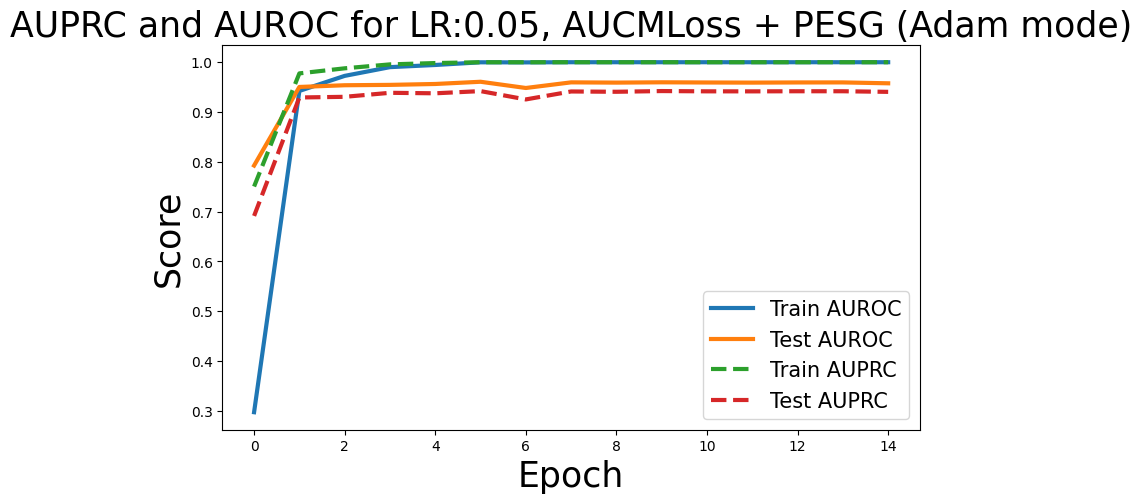

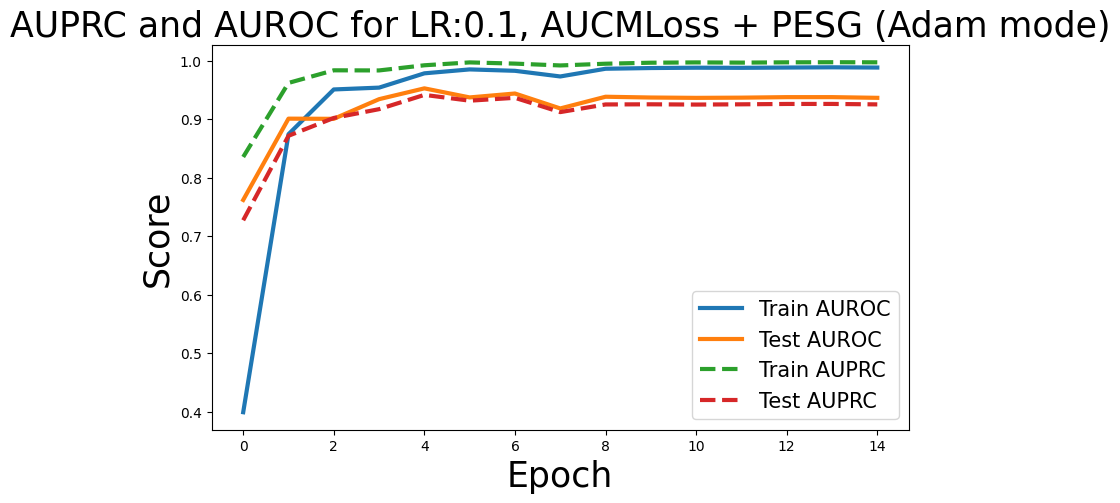

In [11]:
for lr in lr_PESG:
    model = get_resnet18()
    model = model.cuda()
    scheduler = None
    # You can also pass Loss.a, Loss.b, Loss.alpha to optimizer (for old version users)
    loss_fn = AUCMLoss()
    optimizer = PESG(model, 
                    loss_fn=loss_fn,
                    lr=lr, 
                    momentum=0.9,
                    margin=margin, 
                    epoch_decay=epoch_decay, 
                    weight_decay=weight_decay)
    train_auprc, test_auprc, train_auroc, test_auroc = train_model(model, loss_fn, optimizer, scheduler)
    plot_curves(train_auprc, test_auprc, train_auroc, test_auroc, f'LR:{lr}, AUCMLoss + PESG (Adam mode)')